In this short notebook I will briefly explore various Time-Series Forecasting techniques for analyzing a dataset of tickets (in millions) issued for the Paris Metro from 1930-1937. This cool dataset is from The National Bureau of Economic Research's MacroHistory Database, retrieved via the St Louis Federal Reserve's website, where it can be found : https://fred.stlouisfed.org/series/M032ECFRM452NNBR.

In [21]:
# General Imports
import pandas as pd
import numpy as np

#Specific Imports
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import AutoETS
from statsforecast.models import RandomWalkWithDrift
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from utilsforecast.plotting import plot_series



The Data is a monthly univariate time-series. Our goal is to fit a model that forecasts as accurately as possible without explicitly modifying the data. This precludes us from any Feature Engineering by adding things such as moving averages. Still, there remains a wide range of effective tools for the task at hand.

In [22]:
# Load the data
df = pd.read_csv('Paris_Metro_Traffic_Tickets.csv')
df

,DATE,M032ECFRM452NNBR
0,1930-03-01,62.82
1,1930-04-01,58.44
2,1930-05-01,60.32
3,1930-06-01,53.36
4,1930-07-01,50.12
...,...,...
89,1937-08-01,44.57
90,1937-09-01,55.19
91,1937-10-01,62.21
92,1937-11-01,56.98


<AxesSubplot: >

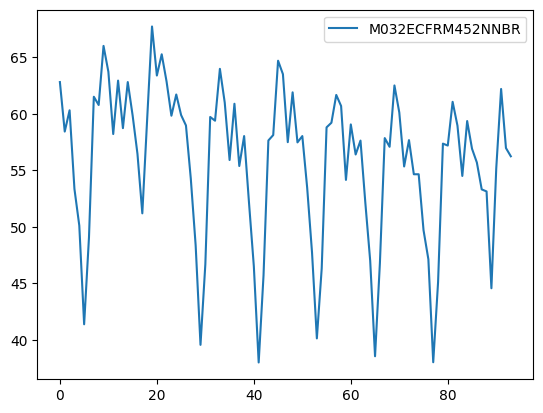

In [23]:
# Plot the Data
df.plot()

The data exhibits a discernible, repeated pattern along with a clear seasonality which can be exploited

In this analysis, we will begin with the StatsForecast library, A Statistical Forecasting package part of the broader Nixtla open-source forecasting ecosystem which contains a very wide range of time-series modeling techniques. The StatsForecast library needs the dataframe to have (at least) three columns - unique_id, y, and ds. We manipulate the dataframe accordingly.

In [24]:
# Renaming
df.rename(columns={"M032ECFRM452NNBR":'y', 'DATE':'ds'}, inplace= True)
df

,ds,y
0,1930-03-01,62.82
1,1930-04-01,58.44
2,1930-05-01,60.32
3,1930-06-01,53.36
4,1930-07-01,50.12
...,...,...
89,1937-08-01,44.57
90,1937-09-01,55.19
91,1937-10-01,62.21
92,1937-11-01,56.98


In [25]:
# Adding unique_id
df.insert(loc= 0, column='unique_id',value='Tickets')
df

,unique_id,ds,y
0,Tickets,1930-03-01,62.82
1,Tickets,1930-04-01,58.44
2,Tickets,1930-05-01,60.32
3,Tickets,1930-06-01,53.36
4,Tickets,1930-07-01,50.12
...,...,...,...
89,Tickets,1937-08-01,44.57
90,Tickets,1937-09-01,55.19
91,Tickets,1937-10-01,62.21
92,Tickets,1937-11-01,56.98


We split the data into training and test sets. The training set consists of the first 5 years, with the test being the remainder ~ 3 yrs.

In [26]:
train_df = df.loc[0:60].copy()
train_df.tail()

,unique_id,ds,y
56,Tickets,1934-11-01,59.22
57,Tickets,1934-12-01,61.68
58,Tickets,1935-01-01,60.70
59,Tickets,1935-02-01,54.16
60,Tickets,1935-03-01,59.07


In [27]:
test_df = df.loc[61:].copy()
test_df.head()

,unique_id,ds,y
61,Tickets,1935-04-01,56.41
62,Tickets,1935-05-01,57.64
63,Tickets,1935-06-01,52.12
64,Tickets,1935-07-01,47.00
65,Tickets,1935-08-01,38.55


We begin with a Baseline Model to compare our performance to.

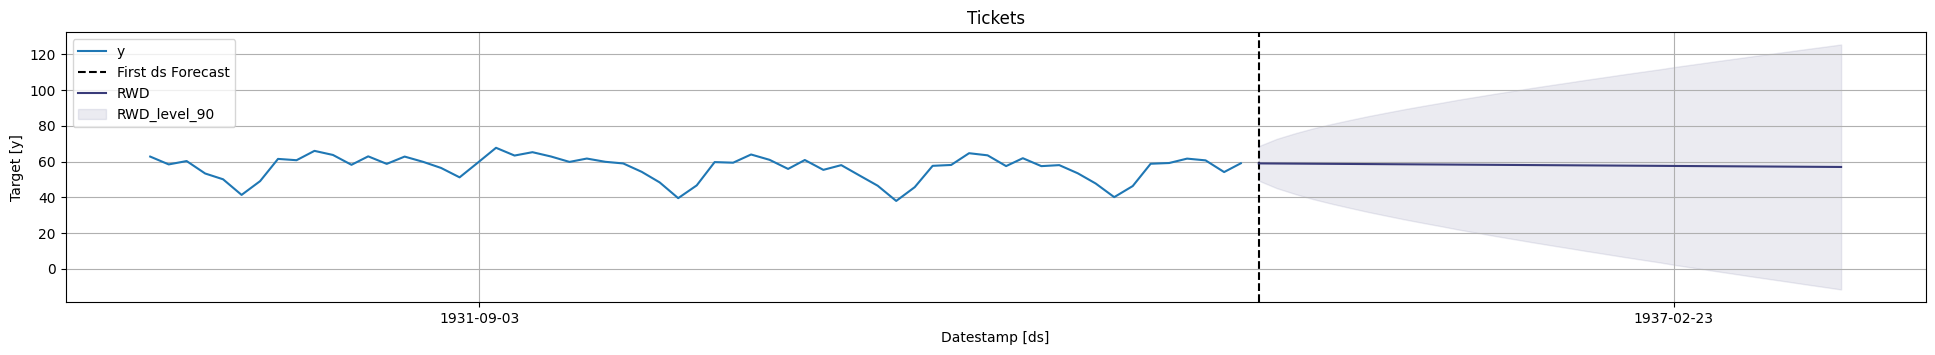

In [28]:
sf = StatsForecast(
    models = [RandomWalkWithDrift()],
    freq = 'M'
)

sf.fit(train_df)

forecast_df = sf.predict(h=33, level=[90])  # 90 percent confidence interval

train_df["ds"]=pd.to_datetime(train_df["ds"])
sf.plot(train_df, forecast_df, level=[90], engine='matplotlib')

We Compute the MSE of the Prediction to get a quantifiable measure of our Forecasting Performance

In [29]:
mean_squared_error(test_df['y'],forecast_df['RWD'])

54.87169621309232

For our first real model choice, we fit the classic Auto Regressive Integrated Moving Average (ARIMA) model. This is a simple but effective model that has had wide success in many applications.

In [30]:

sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'M'
)

sf.fit(train_df)

forecast_df = sf.predict(h=33, level=[90]) 

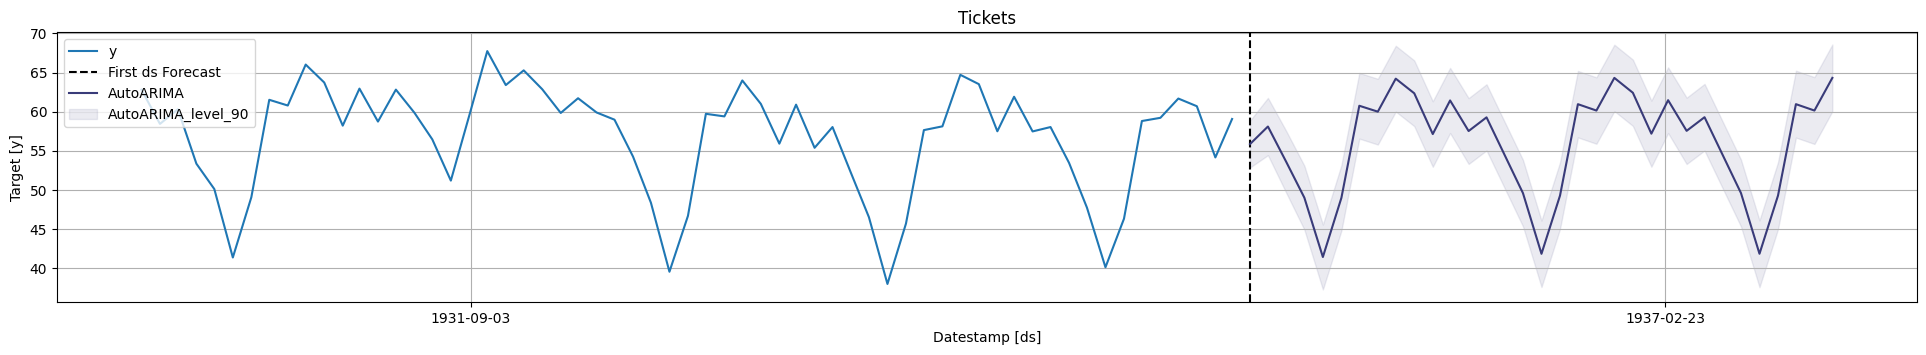

In [31]:
sf.plot(train_df, forecast_df, level=[90], engine='matplotlib')

Visually, the prediction seems to have captured the underlying pattern very well. We compute the MSE to quantify this improvement.

In [32]:
mean_squared_error(test_df['y'],forecast_df['AutoARIMA'])

10.695882444923786

Next, we fit an Exponential Smoothing Model, another popular statistical forecasting technique.

In [33]:
sf = StatsForecast(
    models = [AutoETS(season_length=12)],
    freq = 'M'
)

sf.fit(train_df)

forecast_df = sf.predict(h=33, level=[90]) 

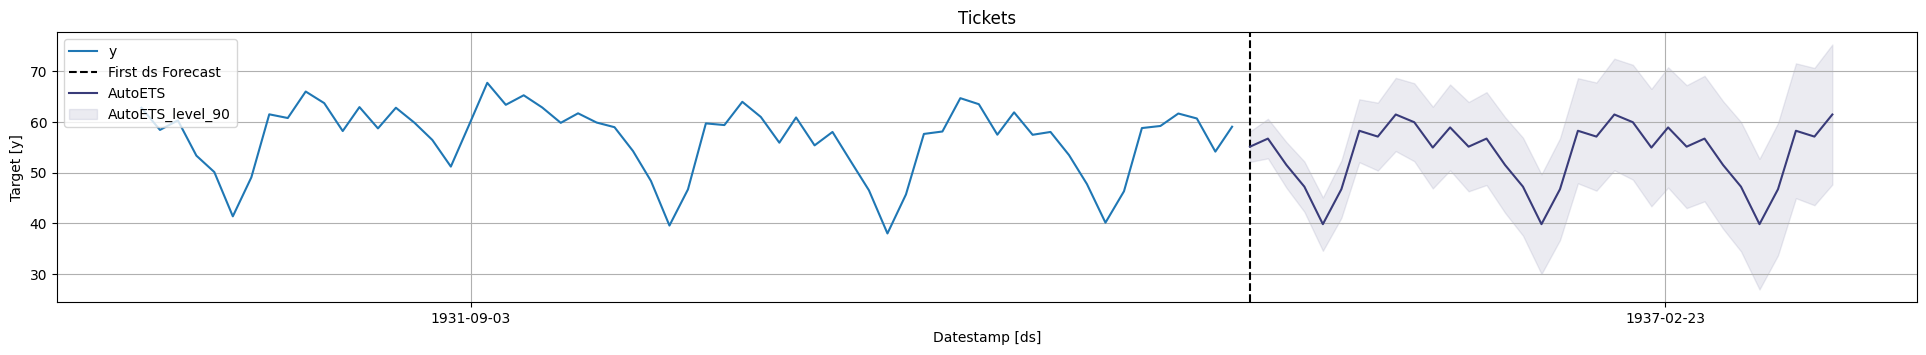

In [34]:
sf.plot(train_df, forecast_df, level=[90], engine='matplotlib')

The model also seems to have captured the pattern nicely. We again compute the MSE to compare

In [35]:
mean_squared_error(test_df['y'],forecast_df['AutoETS'])

6.143417049003517

The Exponential Smoothing model is the best so far. Next, we try some Machine Learning approaches to forecasting, starting with a linear regression with a lag value for the same month from the previous year.

In [36]:
mlf = MLForecast(
    models=LinearRegression(),
    freq='MS',  
    lags=[12], # The Lag Value
    target_transforms=[Differences([1])], 
)
mlf.fit(train_df)
forecast_df = mlf.predict(h=33)

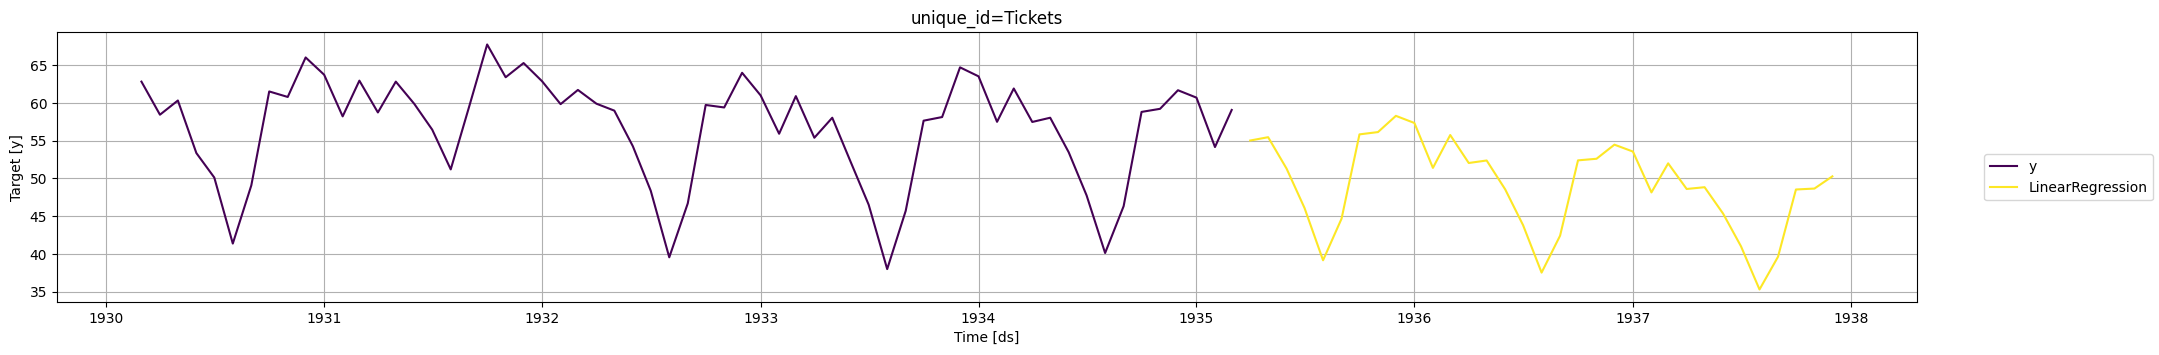

In [37]:
fig = plot_series(train_df,forecast_df)
fig

Visually, the Linear Regression does not appear to capture the pattern as effectively as the other models.

In [38]:
mean_squared_error(test_df['y'],forecast_df['LinearRegression'])

38.00868722351536

The MSE reflects this, performing worse than both of our classical Statistical/Econometric Models. We next attempt Ridge, Lasso, and K Neighest Neighbors Regression.

In [39]:
mlf = MLForecast(
    models=[Ridge(), Lasso(), KNeighborsRegressor()],
    freq='MS',
    target_transforms=[Differences([1])],
    lags=[12],
)

mlf.fit(train_df)
forecast_df = mlf.predict(h=33)

In [40]:
print(mean_squared_error(test_df['y'],forecast_df['Ridge']))
print(mean_squared_error(test_df['y'],forecast_df['Lasso']))
print(mean_squared_error(test_df['y'],forecast_df['KNeighborsRegressor']))

37.895888193127234
32.49851643855901
8.63145757575757


The linear methods continue to perform poorly, while the KNeighbors performs admirably, placing 2nd outperforming the ARIMA. However, our best performing model and final choice remains the Exponential Smoothing Model.